In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import json
import datasets
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'options', 'meta_info', 'answer_idx'],
        num_rows: 10178
    })
})
                                            question  \
0  A 23-year-old pregnant woman at 22 weeks gesta...   
1  A 3-month-old baby died suddenly at night whil...   
2  A mother brings her 3-week-old infant to the p...   
3  A pulmonary autopsy specimen from a 58-year-ol...   
4  A 20-year-old woman presents with menorrhagia ...   

                                              answer  \
0                                     Nitrofurantoin   
1  Placing the infant in a supine position on a f...   
2       Abnormal migration of ventral pancreatic bud   
3                                    Thromboembolism   
4                             Von Willebrand disease   

                                             options meta_info answer_idx  
0  {'A': 'Ampicillin', 'B': 'Ceftriaxone', 'C': '...   step2&3          E  
1  {'A': 'Placing the inf

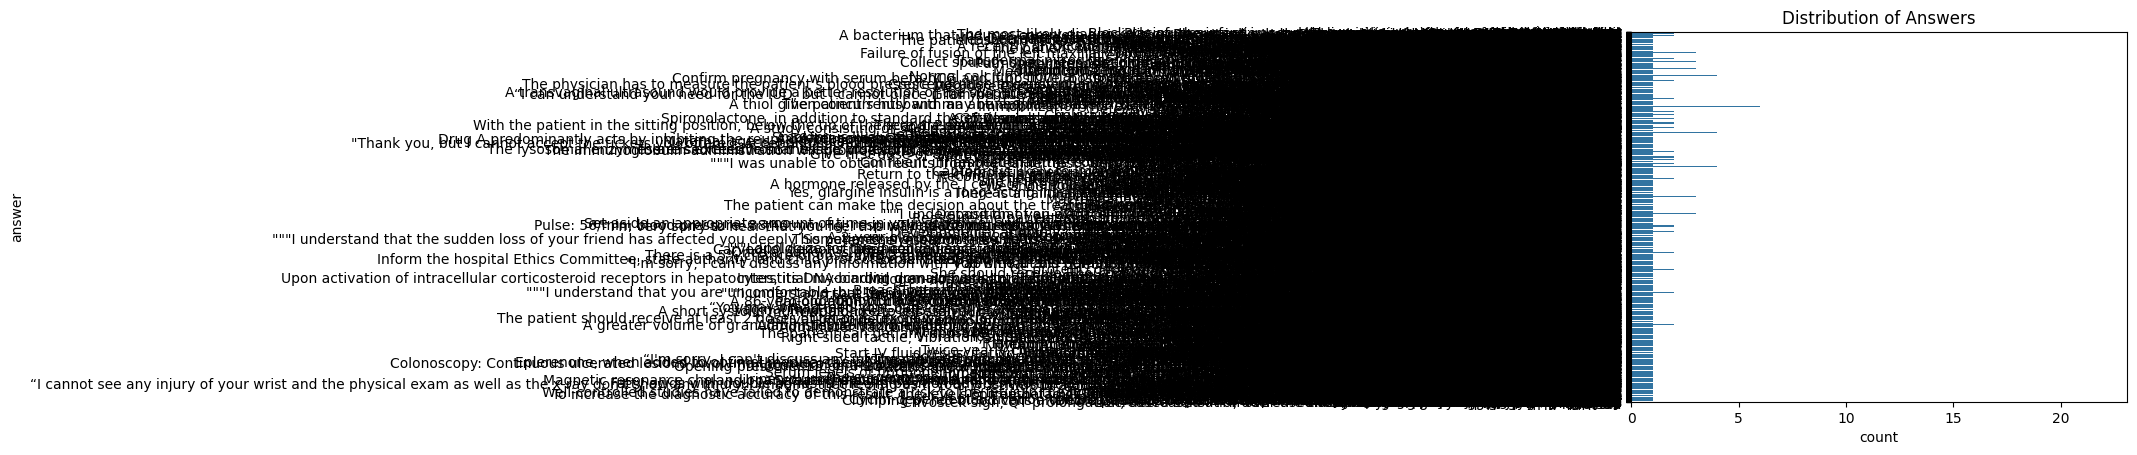

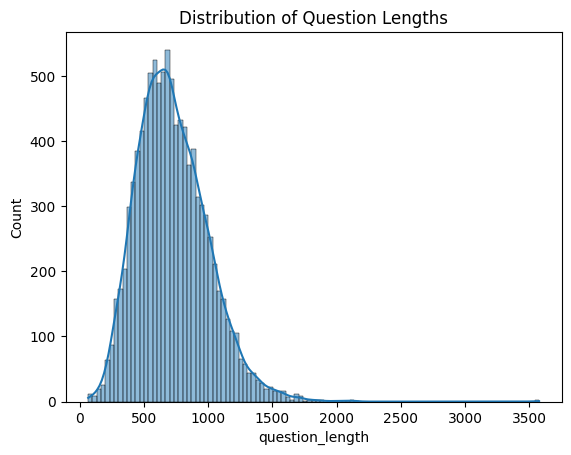

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [19]:
data_files = {"train": "train.jsonl"}
dataset = datasets.load_dataset('json', data_files=data_files)

# Display some basic information about the dataset
print(dataset)

# Convert the dataset to a pandas DataFrame for analysis
df = pd.DataFrame(dataset['train'])

# Display basic statistics and visualizations
print(df.head())

# Plot distribution of answers
sns.countplot(y="answer", data=df)
plt.title("Distribution of Answers")
plt.show()

# Plot distribution of question lengths
df['question_length'] = df['question'].apply(len)
sns.histplot(df['question_length'], kde=True)
plt.title("Distribution of Question Lengths")
plt.show()

# Preprocess the dataset using GPT-2 tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained('gpt2')

# Add a padding token to the tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def preprocess_data(examples):
    inputs = examples['question']
    targets = examples['answer']
    tokenized_inputs = tokenizer(inputs, padding='max_length', truncation=True, max_length=512)
    tokenized_targets = tokenizer(targets, padding='max_length', truncation=True, max_length=128)
    
    return {
        'input_ids': tokenized_inputs['input_ids'], 
        'attention_mask': tokenized_inputs['attention_mask'], 
        'labels': tokenized_targets['input_ids']
    }

tokenized_dataset = dataset['train'].map(preprocess_data, batched=True)

In [20]:
class MEDQADataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.encodings['labels'][idx])
        }
        return item

train_dataset = MEDQADataset(tokenized_dataset)

In [21]:
class gMLPBlock(nn.Module):
    def __init__(self, dim, seq_len, depth, num_heads, ff_mult=4):
        super().__init__()
        self.depth = depth
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * ff_mult),
            nn.GELU(),
            nn.Linear(dim * ff_mult, dim)
        )

    def forward(self, x):
        for _ in range(self.depth):
            x = self.norm(x)
            attn_output, _ = self.attn(x, x, x)
            x = attn_output + x
            ff_output = self.ff(x)
            x = ff_output + x
        return x

class gMLPModel(nn.Module):
    def __init__(self, vocab_size, dim, seq_len, depth, num_heads, ff_mult=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)
        self.gmlp_block = gMLPBlock(dim, seq_len, depth, num_heads, ff_mult)
        self.norm = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, vocab_size)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids) * attention_mask.unsqueeze(-1)
        x = self.gmlp_block(x)
        x = self.norm(x)
        logits = self.fc(x)
        return logits


In [25]:
def train(model, dataset, epochs=5, batch_size=32, lr=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "rocm" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=epochs * len(loader))
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(loader)}")

vocab_size = len(tokenizer)
dim = 512
seq_len = 512
depth = 6
num_heads = 8
model = gMLPModel(vocab_size, dim, seq_len, depth, num_heads)

train(model, train_dataset, epochs=5, batch_size=16, lr=1e-5)

ValueError: Expected input batch_size (2048) to match target batch_size (512).